In [0]:
# default_exp data.exploratory.se.metrics

# Exploration of your data

> This module comprises some of the statistical and inference techniques to describe the inner properties of software data. The submodules might include:
>
> - Descriptive statistics
> - Software Metrics
> - Information Theory
> - Learning Principels Detection (Occams' Razor, Biased data, and Data Snooping)
> - Inference: Probabilistic and Causal

### Specifically in this module

> - Cyclomatic complexity (CYCLO)
> - Coupling Between Objects (CBO)
> - Lack of Cohesion of Methods 5 (LCOM5)
> - Top/Least 20 Occurring Tokens
> - Percentage of redundancy (just Java)
> - How many Type I and Type II clones are in Java datasets?

In [0]:
# #hide
# from nbdev.showdoc import *

In [3]:
!pip install sentencepiece
# !pip install metrics # Outdated Cyclomatic Complexity tool
!pip install lizard
!pip install tree_sitter

In [0]:
# export
# Imports
import pandas as pd
import sentencepiece as sp
from numpy import mean, std
from statistics import median
from scipy.stats import sem, t
import lizard
import matplotlib.pyplot as plt
from tree_sitter import Language, Parser

# TODO: Remove when mongo call is implemented
import os

In [5]:
!git clone https://github.com/tree-sitter/tree-sitter-c
# !git clone https://github.com/tree-sitter/tree-sitter-cpp
!git clone https://github.com/tree-sitter/tree-sitter-java
# !git clone https://github.com/tree-sitter/tree-sitter-javascript
# !git clone https://github.com/tree-sitter/tree-sitter-python

fatal: destination path 'tree-sitter-c' already exists and is not an empty directory.
fatal: destination path 'tree-sitter-java' already exists and is not an empty directory.


In [0]:
# TODO: Replace with actual mongo call
def simulate_getting_dataframes_from_mongo():
    corpus_data = {"system": [], "name": [], "ground_truth": [], "contents": []}
    path = "./source_code"
    for file in os.listdir(path):
        corpus_data["system"].append(None)
        corpus_data["name"].append(file)
        corpus_data["ground_truth"].append("src")
        try:
            with open (os.path.join(path, file), "r", encoding='utf-8') as f:
                corpus_data['contents'].append(f.read())
        except UnicodeDecodeError:
            with open (os.path.join(path, file), "r", encoding='iso-8859-15') as f:
                corpus_data['contents'].append(f.read())
    corpus_df = pd.DataFrame(data = corpus_data)
    return corpus_df

In [0]:
# export
def add_length_col(df, col, length_col_name='length'):
    """Adds a length column with the length of entries in the specified column of a dataframe"""
    df[length_col_name] = df[col].astype(str).apply(len)
    return df

In [0]:
# export
def add_mccabe_metrics(df, col):
    """Adds information about function length and cyclomatic complexity to the corpus dataframe"""
    file_ccn = []
    file_nloc = []
    num_funcs = []
    avg_func_ccn = []
    avg_func_nloc = []
    # avg_func_tok_count = [] # TODO: Figure out how lizard tokenizes
    for i in range(len(df)):
        metrics = lizard.analyze_file.analyze_source_code(df["name"][i], df["contents"][i])
        file_ccn.append(metrics.CCN)
        file_nloc.append(metrics.nloc)
        num_funcs.append(len(metrics.function_list))
        avg_func_ccn.append(metrics.average_cyclomatic_complexity)
        avg_func_nloc.append(metrics.average_nloc)
        # avg_func_tok_count.append(metrics.average_token_count) # TODO: Figure out how lizard tokenizes
    df["file_ccn"] = file_ccn
    df["file_nloc"] = file_nloc
    df["num_funcs"] = num_funcs
    df["avg_func_ccn"] = avg_func_ccn
    df["avg_func_nloc"] = avg_func_nloc
    # df["avg_func_tok_count"] = avg_func_tok_count # TODO: Figure out how lizard tokenizes
    return df

In [0]:
#export
def create_parser_builds(path=None):
    '''Creates a dictionary of tree-sitter parsers for select languages'''
    Language.build_library(
        # Store the library in the `build` directory
        'build/my-languages.so',

        # Include one or more languages
        [
            'tree-sitter-c',
            # 'tree-sitter-cpp',
            'tree-sitter-java',
            # 'tree-sitter-javascript',
            # 'tree-sitter-python'
        ]
    )

    C_LANGUAGE = Language('build/my-languages.so', 'c')
    # CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')
    JAVA_LANGUAGE = Language('build/my-languages.so', 'java')
    # JS_LANGUAGE = Language('build/my-languages.so', 'javascript')
    # PY_LANGUAGE = Language('build/my-languages.so', 'python')
    
    return {'c':C_LANGUAGE, 'java':JAVA_LANGUAGE}

In [0]:
#export
def class_attributes_c(tree, text):
    return 0

In [0]:
#export
def num_methods_c(tree):
    return 0

In [0]:
#export
def distinct_class_attribute_calls_c(tree, atts, file_text):
    return 0

In [0]:
#export
def class_attributes_java(tree, text):
    root_node = tree.root_node
    class_atts = []
    for a in range(len(root_node.children)):
        if root_node.children[a].type == "class_declaration":
            atts = []
            class_dec = root_node.children[a]
            for b in range(len(class_dec.children)):
                if class_dec.children[b].type == "class_body":
                    class_body = class_dec.children[b]
                    for c in range(len(class_body.children)):
                        if class_body.children[c].type == "field_declaration":
                            field_dec = class_body.children[c]
                            for d in range(len(field_dec.children)):
                                if field_dec.children[d].type == "variable_declarator":
                                    word = ""
                                    for i in range(field_dec.children[d].start_byte, field_dec.children[d].end_byte):
                                        word += text[i]
                                    atts.append(word)
            class_atts.append(atts)
    return class_atts

In [0]:
#export
def num_methods_java(tree):
    root_node = tree.root_node
    class_methods = []
    for a in range(len(root_node.children)):
        if root_node.children[a].type == "class_declaration":
            num_methods = 0
            class_dec = root_node.children[a]
            for b in range(len(class_dec.children)):
                if class_dec.children[b].type == "class_body":
                    class_body = class_dec.children[b]
                    for c in range(len(class_body.children)):
                        if class_body.children[c].type == "method_declaration":
                            num_methods += 1
            class_methods.append(num_methods)
    return class_methods

In [0]:
#export
def find_string_in_file(node, pattern, text):
    if len(node.children) > 0:
        count = 0
        for i in node.children:
            count += find_string_in_file(i, pattern, text)
        return count
    else:
        word = ""
        for i in range(node.start_byte, node.end_byte):
            word += text[i]
        if word == pattern:
            # print(f"Found. Start byte: {node.start_point}, end byte: {node.end_point}")
            return 1
        else:
            return 0

In [0]:
#export
def distinct_class_attribute_calls_java(tree, atts, file_text):
    class_index = -1
    class_totals_list = []
    root_node = tree.root_node
    for a in range(len(root_node.children)):
        if root_node.children[a].type == "class_declaration":
            class_index += 1
            class_distinct_att_calls = 0
            class_dec = root_node.children[a]
            for b in range(len(class_dec.children)):
                if class_dec.children[b].type == "class_body":
                    class_body = class_dec.children[b]
                    for c in range(len(class_body.children)):
                        if class_body.children[c].type == "method_declaration":
                            distinct_attribute_calls = 0
                            for attribute in atts[class_index]:
                                if find_string_in_file(class_body.children[c], attribute, file_text):
                                    distinct_attribute_calls += 1
                            class_distinct_att_calls += distinct_attribute_calls
            class_totals_list.append(class_distinct_att_calls)
    return class_totals_list

In [0]:
#export
def get_lcom5(tree, extension, file_text):
    '''Takes in the syntax tree of a file and parses it to calculate the LCOM5 of its classes'''
    num_atts_func_dict = {'c':class_attributes_c, 'java':class_attributes_java}
    num_methods_func_dict = {'c':num_methods_c, 'java':num_methods_java}
    num_att_calls_func_dict = {'c':distinct_class_attribute_calls_c, 'java':distinct_class_attribute_calls_java}
    if extension not in num_atts_func_dict:
        print(f"Tried to get LCOM5 of file with extension '.{extension}', that language is not supported, 0 assigned to column.")
        return [0]
    cursor = tree.walk()
    atts = num_atts_func_dict[extension](tree, file_text)
    meths = num_methods_func_dict[extension](tree)
    dist_att_calls = num_att_calls_func_dict[extension](tree, atts, file_text)
    if len(atts) != len(meths) or len(meths) != len(dist_att_calls):
        print(f"Parser error, inconsistent number of classes found. Returning '0'")
        return [0]
    lcom5_list = []
    for i in range(len(atts)):
        lcom5_list.append((dist_att_calls[i] - (meths[i]*len(atts[i])))/(len(atts[i]) - (meths[i]*len(atts[i]))))
    return lcom5_list
        

In [0]:
#export
def add_lcom5(df, col):
    '''Adds a column with the LCOM5 of each class of each file to the dataframe'''
    lang_builds = create_parser_builds()
    parser = Parser()
    file_lcom5 = []
    for i in range(len(df)):
        ext = df["name"][i].split('.')[-1]
        parser.set_language(lang_builds[ext])
        tree = parser.parse(bytes(df["contents"][i], "utf8"))
        file_lcom5.append(get_lcom5(tree, ext, df["contents"][i]))
    df["file_lcom5"] = file_lcom5
    return df

In [0]:
#export
def flatten_list_of_lists(list_list):
    '''Takes in a list of lists and flattens it, returning a list of each entry'''
    flattened_list = []
    for sublist in list_list:
        for entry in sublist:
            flattened_list.append(entry)
    return flattened_list

In [0]:
# export
def display_numeric_col_stats(col, conf = 0.95, sig_figs = 4):
    """Computes statistical metrics about the entries in a dataframe column"""
    print("Min =", round(col.min(), sig_figs))
    print("Max =", round(col.max(), sig_figs))
    print("Average =", round(col.mean(), sig_figs))
    print("Median =", round(median(col), sig_figs))
    print("Standard Deviation =", round(std(col), sig_figs))
    
    n = len(col)
    m = mean(col)
    std_err = sem(col)
    h = std_err * t.ppf((1 + conf) / 2, n - 1)

    start = m - h
    end = m + h
    print(f"{conf} of data points fall between {round(start, sig_figs)} and {round(end, sig_figs)}")

In [0]:
#export
def display_numeric_col_hist(col, col_name="measure", num_bins=None):
    '''Displays a histogram with a customized number of bins for the data in a specified dataframe column'''
    rng = col.max() - col.min()
    num = len(col)
    stnd_dev = std(col)
    # num_bins = round((rng*(pow(num,1/3)))/(3.49*stnd_dev)) # Bins calculated according to https://academic.oup.com/biomet/article-abstract/66/3/605/232642
    if not num_bins:
        num_bins = 20
    plt.hist(col, num_bins, color="blue", alpha=0.5, edgecolor="black", linewidth=1.0)
    plt.title(col_name + " Histogram")
    plt.ylabel("Value Occurrences")
    plt.xlabel(col_name)
    plt.show()

# Analysis & Visualization

In [23]:
# Retrieve the data
corpus_df = simulate_getting_dataframes_from_mongo()
total_file_count = len(corpus_df)
print("Total files:", total_file_count)

Total files: 55


In [32]:
# Add the new metric columns to the corpus dataframe
corpus_df = add_length_col(corpus_df, 'contents', 'code_length')
corpus_df = add_mccabe_metrics(corpus_df, 'contents')
corpus_df = add_lcom5(corpus_df, 'contents')

ZeroDivisionError: ignored

Min = 979
Max = 35035
Average = 6980.3273
Median = 4406
Standard Deviation = 6470.9868
0.95 of data points fall between 5214.8511 and 8745.8035


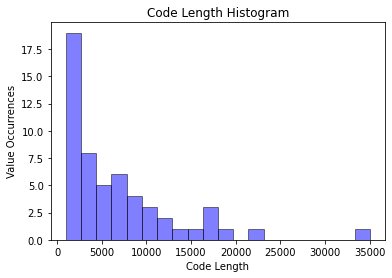

In [0]:
# Print statistical information about the length of each file
display_numeric_col_stats(corpus_df['code_length'])
display_numeric_col_hist(corpus_df['code_length'], "Code Length")

Min = 2
Max = 98
Average = 20.1091
Median = 10
Standard Deviation = 20.2598
0.95 of data points fall between 14.5816 and 25.6366


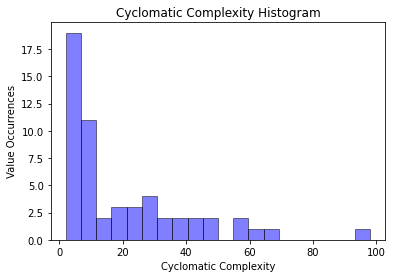

In [0]:
# Print statistical information about the cyclomatic complexity per file
display_numeric_col_stats(corpus_df['file_ccn'])
display_numeric_col_hist(corpus_df['file_ccn'], "Cyclomatic Complexity")

Min = 33
Max = 781
Average = 190.2545
Median = 127
Standard Deviation = 149.8379
0.95 of data points fall between 149.3743 and 231.1347


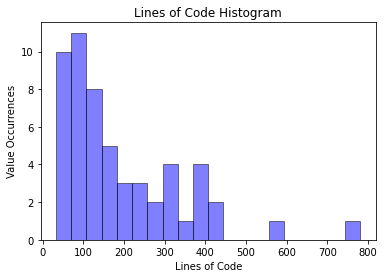

In [0]:
# Print statistical information about the number of lines of code per file
display_numeric_col_stats(corpus_df['file_nloc'])
display_numeric_col_hist(corpus_df['file_nloc'], "Lines of Code")

Min = 2
Max = 22
Average = 6.4727
Median = 5
Standard Deviation = 3.8934
0.95 of data points fall between 5.4105 and 7.535


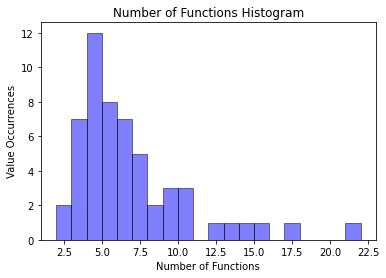

In [0]:
# Print statistical information about the number of functions per file
display_numeric_col_stats(corpus_df['num_funcs'])
display_numeric_col_hist(corpus_df['num_funcs'], "Number of Functions")

Min = 1.0
Max = 6.5333
Average = 2.6903
Median = 2.0
Standard Deviation = 1.5997
0.95 of data points fall between 2.2538 and 3.1267


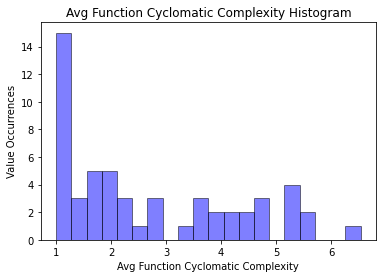

In [0]:
# Print statistical information about the average function cyclomatic complexities per file
display_numeric_col_stats(corpus_df['avg_func_ccn'])
display_numeric_col_hist(corpus_df['avg_func_ccn'], "Avg Function Cyclomatic Complexity")

In [0]:
# Print statistical information about the average function cyclomatic complexity per file
display_numeric_col_stats(corpus_df['avg_func_nloc'])
display_numeric_col_hist(corpus_df['avg_func_nloc'], "Avg Function Lines of Code")

In [0]:
# # Print statistical information about the average LCOM5 per file
display_numeric_col_stats(corpus_df['file_lcom5'])
display_numeric_col_hist(corpus_df['file_lcom5'], "Class LCOM5")

Min = nan
Max = nan
Average = nan


TypeError: ignored

In [0]:
pd.set_option('display.expand_frame_repr', False)
corpus_df.head(20)

In [0]:
# pd.set_option('display.expand_frame_repr', False)
# corpus_df

In [0]:
# https://github.com/priv-kweihmann/multimetric
# The above link is another possible tool to easily calculate code metrics for various languages

In [0]:
# https://books.google.com/books?id=DxuGi5h2-HEC&pg=PA140&lpg=PA140&dq=do+header+files+in+c+have+a+cyclomatic+complexity&source=bl&ots=0WxxjeX9rR&sig=ACfU3U1QnoKnwrsj4YbSQxATeaoYMvBWwg&hl=en&sa=X&ved=2ahUKEwijtqKxhJXoAhUSXa0KHctQD38Q6AEwAnoECAkQAQ#v=onepage&q=do%20header%20files%20in%20c%20have%20a%20cyclomatic%20complexity&f=false
# The abover link goes to an article discussing cyclomatic complexity and c header files

In [0]:
# http://site.iugaza.edu.ps/mroos/files/Software-Metrics1.pdf
# The above link is a pdf that explains every LCOM metric

# Scratch Code (Testing)

In [0]:
Language.build_library(
    # Store the library in the `build` directory
    'build/my-languages.so',

    # Include one or more languages
    [
        'tree-sitter-c',
        'tree-sitter-cpp',
        'tree-sitter-java',
        'tree-sitter-javascript',
        'tree-sitter-python'
    ]
)

C_LANGUAGE = Language('build/my-languages.so', 'c')
CPP_LANGUAGE = Language('build/my-languages.so', 'cpp')
JAVA_LANGUAGE = Language('build/my-languages.so', 'java')
JS_LANGUAGE = Language('build/my-languages.so', 'javascript')
PY_LANGUAGE = Language('build/my-languages.so', 'python')

lang_builds = {'c':C_LANGUAGE, 'cpp':CPP_LANGUAGE, 'java':JAVA_LANGUAGE, 'js':JS_LANGUAGE, 'py':PY_LANGUAGE}

parser = Parser()
ext = 'java'
parser.set_language(lang_builds[ext])
test_df = simulate_getting_dataframes_from_mongo()
tree = parser.parse(bytes(test_df["contents"][1], "utf8"))
# print(test_df["contents"][1])
# root_node = tree.root_node
# num_atts = 0
# for a in range(len(root_node.children)):
#     if root_node.children[a].type == "class_declaration":
#         class_dec = root_node.children[a]
#         for b in range(len(class_dec.children)):
#             if class_dec.children[b].type == "class_body":
#                 class_body = class_dec.children[b]
#                 for c in range(len(class_body.children)):
#                     if class_body.children[c].type == "field_declaration":
#                         field_dec = class_body.children[c]
#                         for d in range(len(field_dec.children)):
#                             if field_dec.children[d].type == "variable_declarator":
#                                 num_atts += 1
# print(num_atts)

In [0]:
root_node = tree.root_node
for a in range(len(root_node.children)):
    if root_node.children[a].type == "class_declaration":
        class_dec = root_node.children[a]
        for b in range(len(class_dec.children)):
            if class_dec.children[b].type == "class_body":
                class_body = class_dec.children[b]
                for c in range(len(class_body.children)):
                    if class_body.children[c].type == "method_declaration":
                        method = class_body.children[c]

In [30]:
print(method.start_point)
print(method.end_point)
print(method.start_byte)
print(method.end_byte)
# print(test_df["contents"][1][558])
# print(test_df["contents"][1])
lines = test_df["contents"][1].split("\n")
print(lines[33])


(22, 4)
(35, 5)
558
975
    	testo[9].setText(DateUtils.parseDate(DateUtils.giveStringOfDate(p.getDataPren())));	    


In [23]:

def find_string_in_file(node, pattern, text):
    if len(node.children) > 0:
        count = 0
        for i in node.children:
            count += find_string_in_file(i, pattern, text)
        return count
    else:
        word = ""
        for i in range(node.start_byte, node.end_byte):
            # print(text[i], end="")
            word += text[i]
        # print()
        if word == pattern:
            print(f"Found. Start byte: {node.start_point}, end byte: {node.end_point}")
            return 1
        else:
            return 0
node = tree.root_node
num_found = find_string_in_file(node, "p", test_df["contents"][1])
print(num_found)

Found. Start byte: (10, 14), end byte: (10, 15)
Found. Start byte: (17, 8), end byte: (17, 9)
Found. Start byte: (26, 19), end byte: (26, 20)
Found. Start byte: (33, 69), end byte: (33, 70)
4


In [0]:
query = JAVA_LANGUAGE.query("""
(binary_expression
    left: ("etichetta")
""")

captures = query.captures(tree.root_node)

SyntaxError: ignored

In [0]:
assert len(captures) == 2
assert captures[0][0] == function_name_node
assert captures[0][1] == "function.def"

In [0]:
cursor = tree.walk()
print(cursor.node.type)
cursor.goto_next_sibling
cursor

program


In [0]:
print(cursor.node.type)
print(cursor.goto_first_child)

program


In [0]:
!pip install multimetric

     |████████████████████████████████| 921kB 6.8MB/s 
  Created wheel for multimetric: filename=multimetric-1.1.3-cp36-none-any.whl size=20170 sha256=0d755e6c6634a50c74264bff0a29dab99642f5051bf7c6ad1c2d3d637a2b1403
  Stored in directory: /root/.cache/pip/wheels/6d/c7/81/52b4323f26674931ea81e0d7589a71081e05e88426004c5331
Successfully built multimetric
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.1.3
    Uninstalling Pygments-2.1.3:
      Successfully uninstalled Pygments-2.1.3


In [0]:
import multimetric

In [0]:
multimetric.rea

In [0]:
if 0:
    print("Hey")

In [0]:
print(round(1236721.8237468732, 3))

1236721.824


In [0]:
!pip install lizard

In [0]:
import subprocess
import json
def add_lizard_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df

In [0]:
!lizard source_code/est.c

  NLOC    CCN   token  PARAM  length  location  
------------------------------------------------
       7      1     35      2      11 est_logger_stderr@9-19@source_code/est.c
      11      2     53      2      16 est_log_msg@27-42@source_code/est.c
      14      3     66      3      24 est_log@46-69@source_code/est.c
      18      2    154      1      23 printStackTrace@73-95@source_code/est.c
      18      5     91      1      31 est_log_backtrace@99-129@source_code/est.c
       3      1      9      1       3 est_get_version@136-138@source_code/est.c
       3      1      9      1       3 est_get_api_level@148-150@source_code/est.c
       7      2     43      1       9 est_log_version@156-164@source_code/est.c
      10      2     46      2      16 est_init_logger@181-196@source_code/est.c
       4      1     11      1       4 est_enable_backtrace@213-216@source_code/est.c
      42      9    202      3      52 est_read_x509_request@239-290@source_code/est.c
      29      5    135     

In [0]:
!metrics source_code/est.c

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python           9       0      3 
----- ------------------------------ ----------- ------- ------ 
    1                          Total           9       0      3 


In [0]:
import lizard

In [0]:
i = lizard.analyze_file("source_code/est.c")

In [0]:
print(i.CCN)

204


In [0]:
print(i.__dict__)

{'filename': 'source_code/est.c', 'nloc': 1005, 'function_list': [<lizard.FunctionInfo object at 0x7f137fc5fc18>, <lizard.FunctionInfo object at 0x7f137fc5fd68>, <lizard.FunctionInfo object at 0x7f137fc5fb00>, <lizard.FunctionInfo object at 0x7f137fc5ff28>, <lizard.FunctionInfo object at 0x7f137fc5ff98>, <lizard.FunctionInfo object at 0x7f137fc5ffd0>, <lizard.FunctionInfo object at 0x7f137fc5f978>, <lizard.FunctionInfo object at 0x7f137fc6b898>, <lizard.FunctionInfo object at 0x7f137fc6b080>, <lizard.FunctionInfo object at 0x7f137fc6b0f0>, <lizard.FunctionInfo object at 0x7f137fc6b160>, <lizard.FunctionInfo object at 0x7f137fc6b128>, <lizard.FunctionInfo object at 0x7f137fc6b2b0>, <lizard.FunctionInfo object at 0x7f137fc6b208>, <lizard.FunctionInfo object at 0x7f137fc6b3c8>, <lizard.FunctionInfo object at 0x7f137fc6b470>, <lizard.FunctionInfo object at 0x7f137fc6b550>, <lizard.FunctionInfo object at 0x7f137fc6b5c0>, <lizard.FunctionInfo object at 0x7f137fc6b668>, <lizard.FunctionInfo o

In [0]:
for i in range(len(i.function_list)):
  

SyntaxError: ignored

In [0]:
print(i.function_list[0].__dict__)

{'cyclomatic_complexity': 3, 'nloc': 8, 'token_count': 35, 'name': 'func', 'long_name': 'func( )', 'start_line': 1, 'end_line': 10, 'parameters': [], 'filename': 'thing.py', 'top_nesting_level': 0, 'length': 10, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}


In [0]:
print(len(i.function_list))

37


In [0]:
i

In [0]:
!metrics thing.py

Metrics Summary:
Files                       Language        SLOC Comment McCabe 
----- ------------------------------ ----------- ------- ------ 
    1                         Python          32       0      9 
----- ------------------------------ ----------- ------- ------ 
    1                          Total          32       0      9 


In [0]:
thing = lizard.analyze_file("thing.py")
print(thing.__dict__)
print(thing.CCN)
for i in range(len(thing.function_list)):
    print(thing.function_list[i].__dict__)


{'filename': 'thing.py', 'nloc': 32, 'function_list': [<lizard.FunctionInfo object at 0x7f47bee93198>, <lizard.FunctionInfo object at 0x7f47bee932e8>, <lizard.FunctionInfo object at 0x7f47bee933c8>, <lizard.FunctionInfo object at 0x7f47bee93630>, <lizard.FunctionInfo object at 0x7f47bee935f8>, <lizard.FunctionInfo object at 0x7f47bee93400>], 'token_count': 145}
12
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 5, 'end_line': 6, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 1, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': '__init__', 'long_name': '__init__( self )', 'start_line': 9, 'end_line': 10, 'parameters': ['self'], 'filename': 'thing.py', 'top_nesting_level': 2, 'length': 2, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0}
{'cyclomatic_complexity': 1, 'nloc': 2, 'token_count': 10, 'name': 'delete',

In [0]:
thing.filename

'source_code/est.c'

In [0]:
thing.nloc

1005

In [0]:
print(thing.functions_average)

<bound method FileInformation.functions_average of <lizard.FileInformation object at 0x7f5ed935c978>>


In [0]:
i = lizard.analyze_file.analyze_source_code("AllTests.cpp", "int foo(){}")

In [0]:
i.__dict__

{'filename': 'AllTests.cpp',
 'function_list': [<lizard.FunctionInfo at 0x7f137fbacc18>],
 'nloc': 1,
 'token_count': 6}

In [0]:
i.CCN

1

In [0]:
lizard.analyze_file.analyze_source_code("AllTests.py", "def foo():\n\tif (True): \n\tprint('HI')").CCN

2

In [0]:
import subprocess
import json
def add_mccabe_metrics(df, col):
    mccabe = []
    sloc = []
    comments = []
    ratio = []
    for i in range(len(df)):
        if i == 99:
            print("At file #100", end="")
        if ((i + 1) % 200) == 0:
            print(", file #" + str(i + 1), end="")
        ext = df["file_name"][i].split('.')[-1]
        if ext == 'h':
            ext = 'c'
        with open(f"temp_file.{ext}", "w", encoding='UTF-8') as fp:
            fp.write(df[col][i])
        out = subprocess.Popen(['metrics', '-q', '--format=json', f"temp_file.{ext}"], 
                               stdout=subprocess.PIPE, 
                               stderr=subprocess.STDOUT)
        stdout,stderr = out.communicate()
        metrics_data = json.loads(stdout)
        mccabe.append(metrics_data['files'][f"temp_file.{ext}"]['mccabe'])
        sloc.append(metrics_data['files'][f"temp_file.{ext}"]['sloc'])
        comments.append(metrics_data['files'][f"temp_file.{ext}"]['comments'])
        ratio.append(metrics_data['files'][f"temp_file.{ext}"]['ratio_comment_to_code'])
#         print(mccabe_data['files'][f'temp_file.{LANGUAGE}'].keys())
        os.remove(f"temp_file.{ext}")
    df["complexity"] = mccabe
    df["code_lines"] = sloc
    df["comments"] = comments
    df["ratio_comment_to_code"] = ratio
    return df